In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
from skimage.transform import resize
import torch.nn.functional as F

import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
def get_initial_points(path_svg, target_="", device=None):
    # target = torch.from_numpy(skimage.io.imread(target_)).to(torch.float32) / 255.0
    # # target = target.pow(gamma)
    # target = target.to(pydiffvg.get_device())
    # target = target.unsqueeze(0)
    # target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    # print("all_points", all_points)
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    masked_im, mask = get_mask_u2net(target, device)
    
    # if args.mask_object:
    #     target = masked_im
    # if args.fix_scale:
    #     target = utils.fix_image_scale(target)

    transforms_ = []
    transforms_.append(transforms.Resize(
        image_scale, interpolation=PIL.Image.BICUBIC))
    transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)

    target_ = data_transforms(target).unsqueeze(0).to(device)
    mask = Image.fromarray((mask*255).astype(np.uint8)).convert('RGB')
    mask = data_transforms(mask).unsqueeze(0).to(device)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    return target_, mask
    
def get_mask_u2net(pil_im, device, use_gpu=True):
    w, h = pil_im.size[0], pil_im.size[1]
    im_size = min(w, h)
    print(im_size)
    data_transforms = transforms.Compose([
        transforms.Resize(min(320, im_size), interpolation=PIL.Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(pil_im).unsqueeze(0).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1

    # opposite mask (mask the object insteadof background)
    # predict_dilated_back = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0)
    
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    mask = resize(mask, (h, w), anti_aliasing=False)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")
    im_np = np.array(pil_im)
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)
    
    return im_final, mask


In [19]:
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/complex-scene-crop.png"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

# target, mask = get_target(target_, device, image_scale=224)

target_ = "/home/vinker/dev/input_images/scaled_clipasso/dog.1018.png"
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

target, mask = get_target(target_, device, image_scale=224)

397


(15, 6, 209, 218)
(224, 224, 3)
(124, 100)


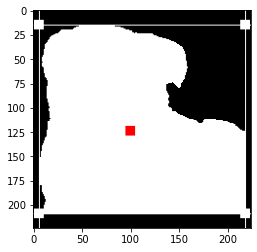

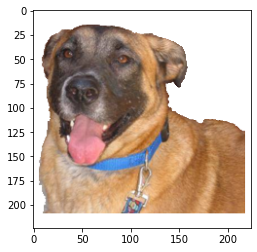

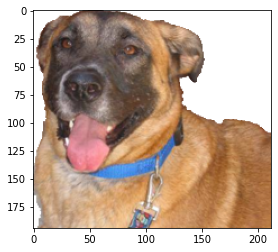

80 82


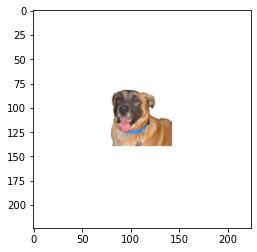

In [21]:
from skimage import data, util
from skimage.measure import label, regionprops

# mask_back = mask
im_scale = 224
mask_np = mask[0,0].cpu().numpy()
label_img = label(mask_np, connectivity=mask_np.ndim)
props = regionprops(label_img)
bbox = props[0].bbox #(min_row, min_col, max_row, max_col)
print(bbox)
bbox_ = [min(b, 224 - 1) for b in bbox]

b_mask_np = np.stack([mask_np, mask_np, mask_np], axis=-1)
print(b_mask_np.shape)
b_mask_np[bbox_[0]] = [1,1,1]
b_mask_np[:, bbox_[1]] = [1,1,1]
b_mask_np[bbox_[2]] = [1,1,1]
b_mask_np[:, bbox_[3]] = [1,1,1]
b_mask_np[bbox_[0] - 5: bbox_[0] + 5, bbox_[1] - 5 : bbox_[1] + 5] = [1,1,1]
b_mask_np[bbox_[0] - 5: bbox_[0] + 5, bbox_[3] - 5 : bbox_[3] + 5] = [1,1,1]
b_mask_np[bbox_[2] - 5: bbox_[2] + 5, bbox_[1] - 5 : bbox_[1] + 5] = [1,1,1]
b_mask_np[bbox_[2] - 5: bbox_[2] + 5, bbox_[3] - 5 : bbox_[3] + 5] = [1,1,1]

cent = props[0].centroid
cent = (int(cent[0]), int(cent[1]))
print(cent)
# b_mask_np[bbox[0] - 15: bbox[0] + 15, bbox[1] - 15 : bbox[1] + 15] = [1,1,1]
b_mask_np[cent[0] - 5: cent[0] + 5, cent[1] - 5 : cent[1] + 5] = [1,0,0]
plt.imshow(b_mask_np)
plt.show()

im_final = (target * mask)#
im_final[mask == 0] = 1
im_final = im_final[0].permute(1,2,0).cpu().numpy()
# im_final[cent[0] - 5: cent[0] + 5, cent[1] - 5 : cent[1] + 5] = [1,0,0]
# im = target * mask_back
# print(im.shape)
plt.imshow(im_final)
plt.show()

im = (im_final * 255).astype(np.uint8)
im_cut = im[bbox_[0]:bbox_[2], bbox_[1]:bbox_[3]]
im_cut = Image.fromarray(im_cut).convert('RGB')
# im_cut = Image.fromarray(im).convert('RGB')
plt.imshow(im_cut)
plt.show()

scale_factor = 0.3
im_scaled = im_cut.resize((int(im_cut.size[0] * scale_factor), int(im_cut.size[1] * scale_factor)))
# plt.imshow(im_scaled)
# plt.show()

new_image = Image.new("RGB", Image.fromarray(im).convert('RGB').size, "WHITE")
# Paste the image on the background.
up_left_y = int(bbox_[0] + (im_cut.size[1] * (1 - scale_factor) // 2))
up_left_x = int(bbox_[1] + (im_cut.size[0] * (1 - scale_factor) // 2))

# up_left_x, up_left_y = int(224 * ((1 - scale_factor) / 2)) , int(224 * ((1 - scale_factor) / 2))
print(up_left_x, up_left_y)
new_image.paste(im_scaled, (up_left_x, up_left_y))
new_image.save("/home/vinker/dev/input_images/scaled_clipasso/dog.1018_03.png")
new_image_ = np.array(new_image)
# new_image_[cent[0] - 5: cent[0] + 5, cent[1] - 5 : cent[1] + 5] = [255,0,0]
plt.imshow(new_image_)
plt.show()


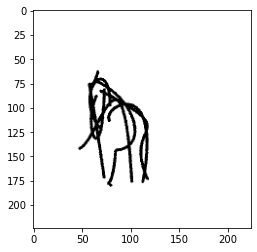

(224, 224, 3)


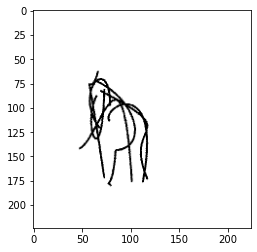

(224, 224, 3)


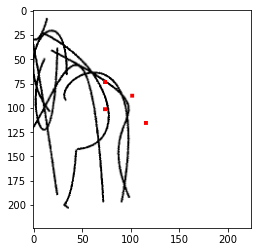

NameError: name 'im_final' is not defined

In [4]:

third = 224 // 3
third_q = third // 5
far_s = third - 30
# imageio.imsave("black_square.png", im)
points_vars_np = np.array([[[third,third],[third + 2 * third_q, third + third_q], [third, third + 2 * third_q], [third + 3  * third_q, third + 3  * third_q]]])
                        # [],
                        # [],
                        # []])

canvas_size=224
num_strokes=8
num_cp=4

path_svg = "baseline_horse_small_RN1_8s_seed0_best.svg"
points_vars = get_initial_points(path_svg, target_="", device=device)
points_vars = torch.stack(points_vars).unsqueeze(0).to(device)#torch.tensor(points_vars_np).unsqueeze(0).to(device)
points_vars = points_vars / canvas_size
points_vars = 2*points_vars-1

widths = torch.ones(num_strokes)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224).detach().cpu().numpy()
print(im.shape)
# for s in points_vars_np:
#     for p in s:
#         im[p[1] - 2 : p[1] + 2, p[0] - 2 :p[0] + 2] = (1,0,0)
plt.imshow(im)
plt.show()

scale_factor = 0.6
points_vars2 = points_vars.clone()
points_vars2_np = points_vars_np.copy()
for i in range(points_vars.shape[0]):
    # for p in points_vars[i]:
    points_vars2[i] = points_vars[i] * (1 / scale_factor) - ((1 - scale_factor) / 2)
    # points_vars2_np[i] = points_vars_np[i] * 2
im = render_points(points_vars2, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224).detach().cpu().numpy()
print(im.shape)
for s in points_vars2_np:
    for p in s:
        im[p[1] - 2 : p[1] + 2, p[0] - 2 :p[0] + 2] = (1,0,0)
plt.imshow(im)
plt.show()

plt.imshow(im_final)
plt.show()
